# Time series Classification

# Installation

In [ ]:
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Connect to the drive






In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/homework2

/gdrive/My Drive/homework2


# Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import warnings
import logging
from scipy import signal
from scipy.fft import fftshift

#from tsaug.visualization import plot

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


# Set the seed

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Unzip and inspect the dataset

In [ ]:
# Unzip the dataset (on the disk)
!unzip dataset_homework2.zip -d dataset

Archive:  dataset_homework2.zip
  inflating: dataset/X.npy           
  inflating: dataset/y.npy           


In [ ]:
# Set dataset dir
dataset_dir = 'dataset'

In [ ]:
# load to RAM from disk
X = np.load(os.path.join(dataset_dir, 'X.npy'))
print("Found {} X:".format(len(X)))
print(X.shape)
print(X)

y = np.load(os.path.join(dataset_dir, 'y.npy'))
print("Found {} y:".format(len(y)))
print(y.shape)
print(y)

Found 2429 X:
(2429, 36, 6)
[[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00
   -6.1887e+01]
  [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00
    5.8914e+01]
  [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01
    1.0665e+01]
  ...
  [ 1.1982e+02  2.1849e+02  1.6398e+03  5.9787e+02  2.1922e+03
    1.8484e+01]
  [ 9.1591e+01  1.0378e+02  1.8238e+03  1.2460e+03  1.1301e+04
    7.5107e+02]
  [ 4.3719e+01  3.0689e+01  9.5092e+02  8.5927e+02  8.1331e+03
    9.8883e+02]]

 [[ 2.4209e+00 -5.6039e-01  2.3654e+01 -3.8171e+00  1.3721e+00
    8.2510e+00]
  [ 1.6847e+00  2.3989e+01  1.7803e+01 -1.9575e+01 -8.2534e+00
   -2.3959e+01]
  [ 5.0692e-01  5.0281e+01  5.1196e+01  1.6036e+01  7.2974e-01
   -1.8185e+01]
  ...
  [-1.5618e+01 -7.4233e+00  3.7833e+00  1.6565e+00 -1.0438e+01
   -5.5229e+00]
  [-1.0702e+01 -6.3568e+00 -4.6464e+00  6.7957e-01 -5.5260e+00
    1.9070e+01]
  [-4.6352e+00 -3.2769e+00 -5.9048e+00 -1.9564e-01  1.1487e+00
    2.3275e+01]]

 [[ 3.96

In [ ]:
sequence_length, num_features = X.shape[1:]
print(sequence_length, num_features)

36 6


In [ ]:
print(y.dtype)
print(set(y))

int32
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


0        0
1        0
2        0
3        0
4        0
        ..
2424    11
2425    11
2426    11
2427    11
2428    11
Length: 2429, dtype: int32
0      34
1     123
2     270
3     381
4      62
5     153
6     313
7      68
8     120
9     777
10     77
11     51
dtype: int64


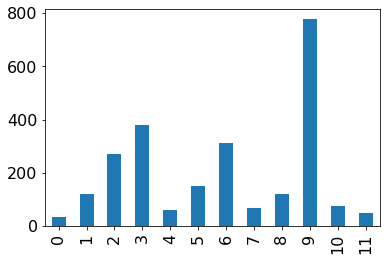

In [ ]:
print(pd.Series(y))
y_series = pd.Series(y)
# count how many things there are for classes
print(y_series.value_counts().sort_index())
y_series.value_counts().sort_index().plot.bar()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-37e1a9c0f55b>", line 23, in <module>
    plot_example(X, y, i, save_in)
  File "<ipython-input-11-37e1a9c0f55b>", line 14, in plot_example
    fig.savefig(save_in)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/figure.py", line 2203, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/backend_bases.py", line 2119, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py", line 535, in print_png
    with cbook.open_file_cm(filename_or_obj, "wb") as fh:
  File "/usr/lib/python3.8/contextlib.py", line 113, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py", line 418, in

KeyboardInterrupt: ignored

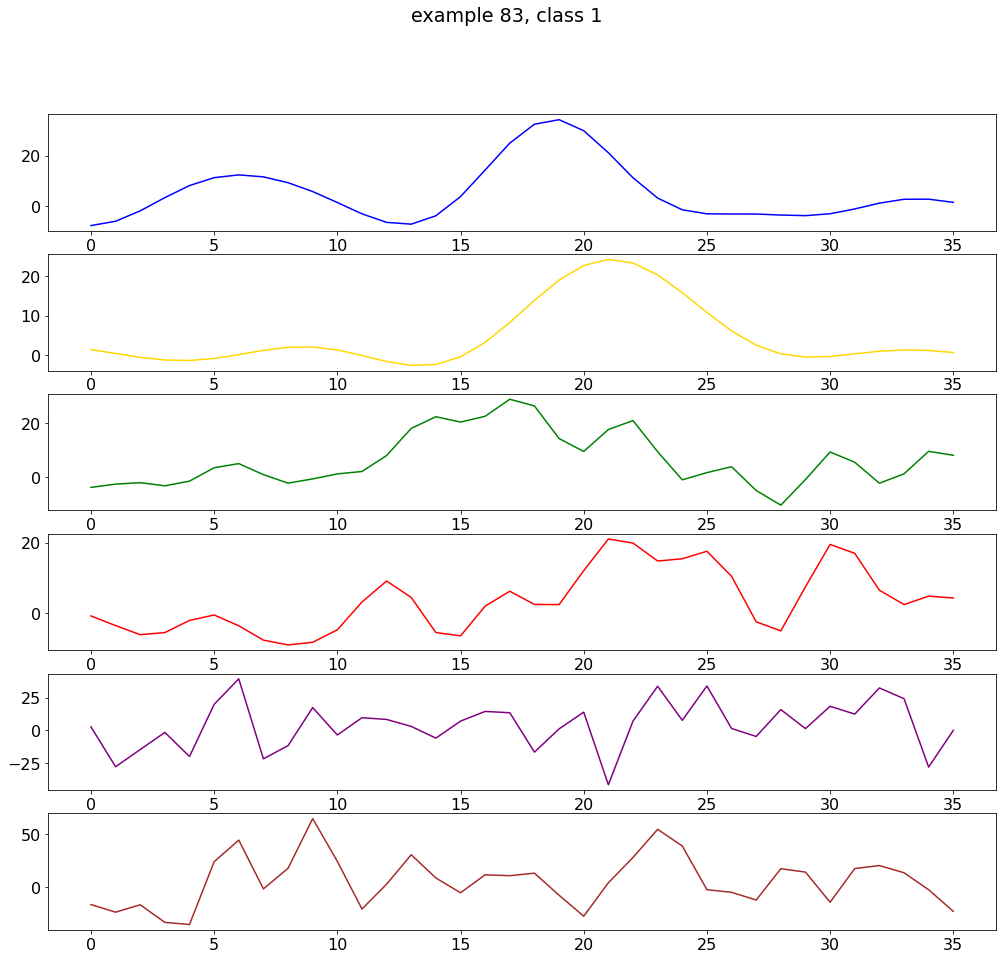

In [ ]:
def plot_example(X, y, example_id, save_in=None):
    example = X[example_id]
    cls = y[example_id]
    n_features = 6
    colors = ["blue", "gold", "green", "red", "purple", "brown"]
    fig, axs = plt.subplots(n_features, 1)
    for i in range(n_features):
        axs[i].plot(example[:, i], color=colors[i])
    fig.set_size_inches(17, 15)
    fig.suptitle(f"example {example_id}, class {cls}")
    if save_in is None:
        fig.show()
    else:
        fig.savefig(save_in)
        plt.close("all")

from pathlib import Path
plot_dir = Path("all_data")
plot_dir.mkdir(exist_ok=True)
for i, yi in enumerate(y):
    save_in = plot_dir / f"class_{yi}" / f"example_{i}.png"
    save_in.parent.mkdir(exist_ok=True)
    plot_example(X, y, i, save_in)

plot_example(X, y, 900)

In [ ]:
num_classes = len(set(y))
for c in range(num_classes):
    print(np.concatenate(X[y == c], axis=0).shape)

def plot_series(X, class_id, save_in=None):
    n_features = 6
    colors = ["blue", "gold", "green", "red", "purple", "brown"]
    fig, axs = plt.subplots(n_features, 1)
    for i in range(n_features):
        axs[i].plot(X[:, i], color=colors[i])
    fig.set_size_inches(17, 15)
    fig.suptitle(f"class {class_id}")
    if save_in is None:
        fig.show()
    else:
        fig.savefig(save_in)
        fig.clear()
        plt.close(fig)

from pathlib import Path
plot_dir = Path("all_data_concatenated")
plot_dir.mkdir(exist_ok=True)
for c in range(num_classes):
    save_in = plot_dir / f"class_{c}.png"
    Xc = np.concatenate(X[y == c], axis=0)
    plot_series(Xc, c, save_in)


(1224, 6)
(4428, 6)
(9720, 6)
(13716, 6)
(2232, 6)
(5508, 6)
(11268, 6)
(2448, 6)
(4320, 6)
(27972, 6)
(2772, 6)
(1836, 6)


(87444, 6)
                  0             1             2             3             4  \
count  87444.000000  87444.000000  87444.000000  87444.000000  87444.000000   
mean       9.571373     17.942852     26.531002     32.373994     33.874759   
std      250.301522    776.638186    699.091261    681.845382    669.444098   
min    -3420.000000 -11585.000000 -10289.000000  -8009.900000  -7326.600000   
0.1%   -1118.735500  -6807.267700  -5450.352100  -4234.197700  -3565.739400   
1%      -300.480000  -1434.721000  -1373.271000  -1093.967000   -853.078300   
25%       -3.574775     -1.703225     -1.704875     -2.474225     -4.052300   
50%        0.275515      0.410780      0.652080      0.944095      1.286750   
75%        5.568825      4.117225      6.932275      9.922200     14.084250   
99%      453.875400   1498.582000   1530.440000   1403.939000   1331.240000   
99.9%   1804.310000   9299.198900   8061.961800   6770.253400   6488.893400   
max    32932.000000  44394.000000  37032.

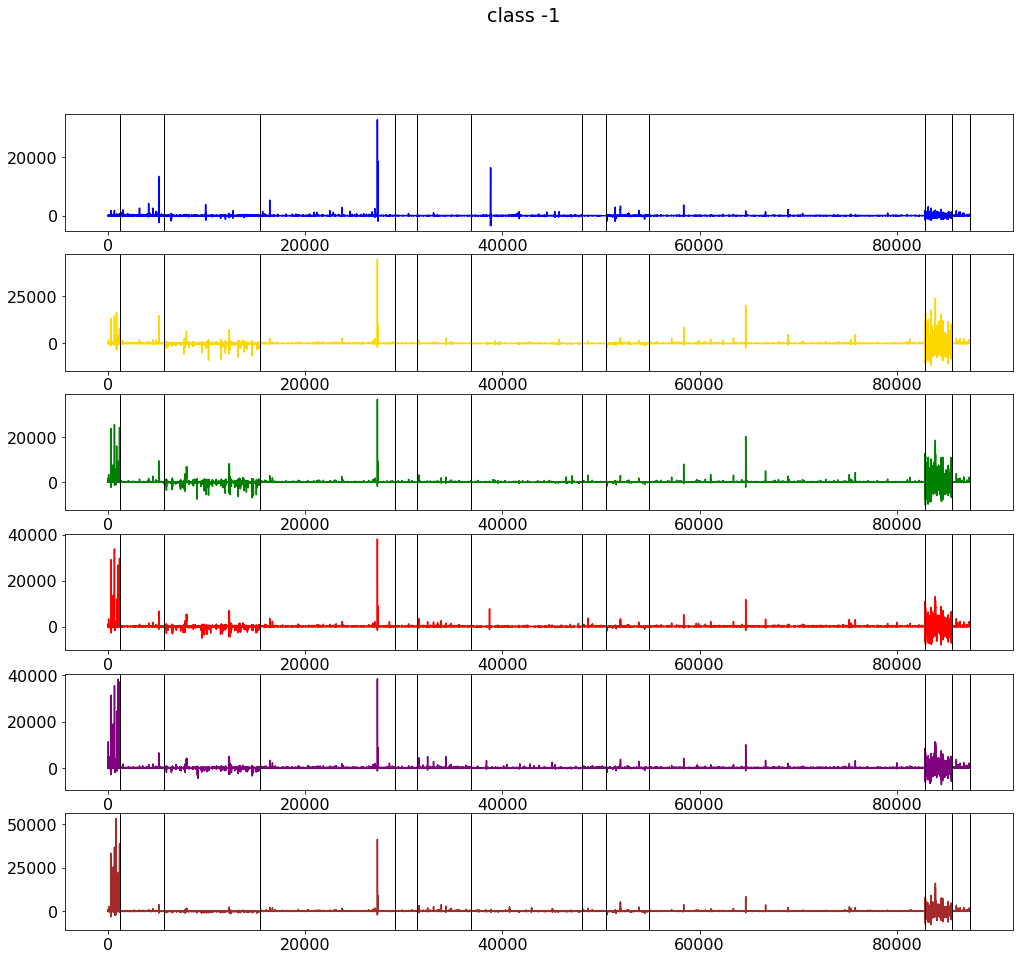

In [ ]:
X_concat = np.concatenate(X, axis=0)
def plot_series(X, class_id, vertical_lines=None, save_in=None):
    if vertical_lines is None:
        vertical_lines = []
    colors = ["blue", "gold", "green", "red", "purple", "brown", "orange"]
    m, M = X.flatten().min(), X.flatten().max()
    fig, axs = plt.subplots(X.shape[1], 1)
    for i in range(X.shape[1]):
        axs[i].plot(X[:, i], color=colors[i])
        for vx in vertical_lines:
            axs[i].axvline(vx, m, M, linewidth=1, color='black')
    fig.set_size_inches(17, 15)
    fig.suptitle(f"class {class_id}")
    if save_in is None:
        fig.show()
    else:
        fig.savefig(save_in)
        fig.clear()
        plt.close(fig)

vertical_lines = y_series.value_counts().sort_index().cumsum().values * sequence_length
plot_series(X_concat, -1, vertical_lines)
print(X_concat.shape)
print(pd.DataFrame(X_concat).describe(percentiles=[0.001, 0.01, .25, .5, .75, 0.99, 0.999]))

In [ ]:
X_means = X_concat.mean(axis=1, keepdims=True)
X_concat_with_mean = np.concatenate([X_concat, X_means], axis=1)

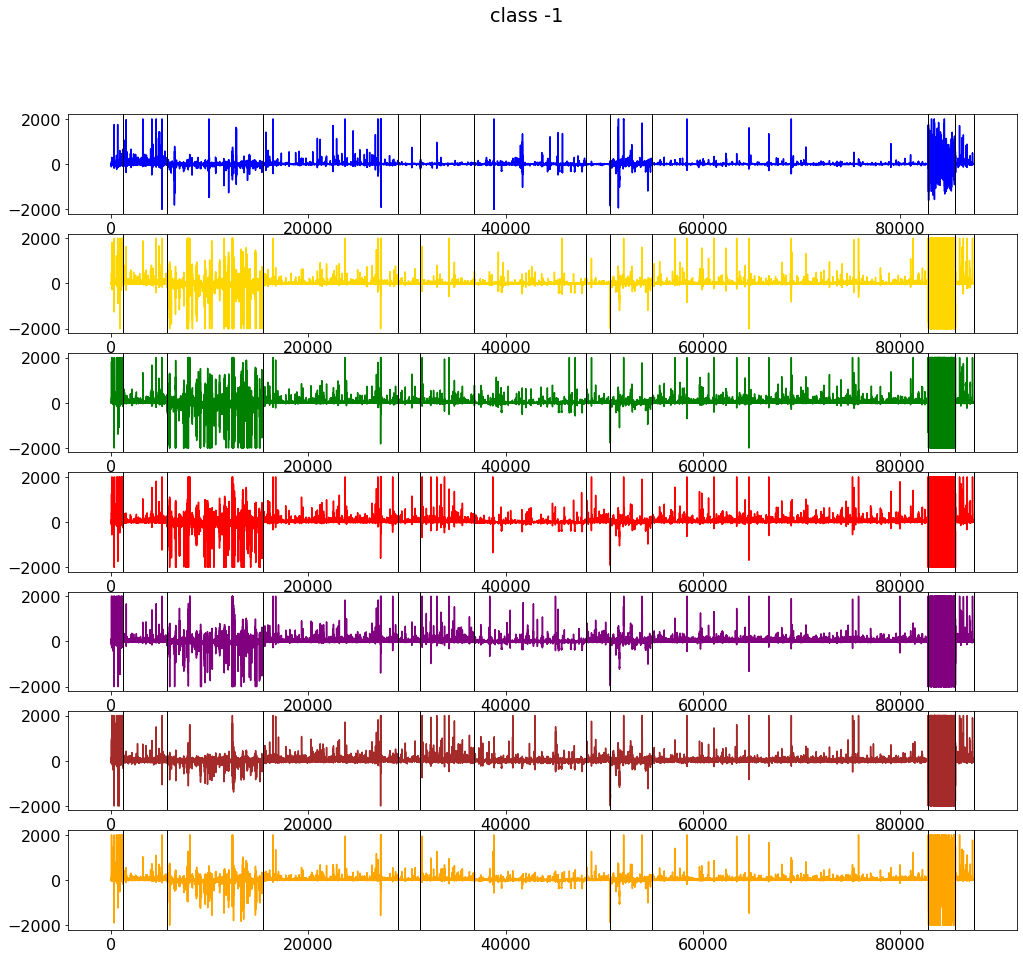

In [ ]:
X_concat_clipped = X_concat_with_mean.clip(-2000, 2000)
plot_series(X_concat_clipped, -1, vertical_lines)

# Split and normalize the dataset

In [ ]:
# Split the dataset using train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
# Inspect the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1700, 36, 6), (729, 36, 6), (1700,), (729,))

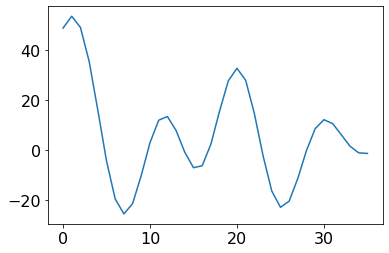

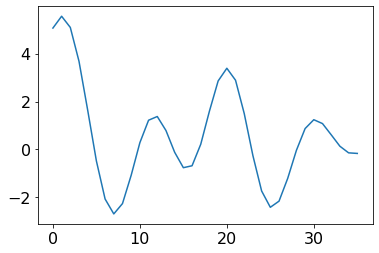

In [ ]:
# Standardize data: each feature will have mean 0 and variance 1

def preprocess(X, scaler=None, val_min=None, val_max=None):
    X_clipped = X.clip(val_min, val_max)
    # return X_clipped, None
    num_examples, sequence_length, num_features = X.shape
    if scaler is None:
        scaler = RobustScaler()
        scaler = scaler.fit(X_train.reshape([-1, num_features]))
    X_standardized = scaler.transform(X_clipped.reshape([-1, num_features])).reshape([num_examples, sequence_length, num_features])
    return X_standardized, scaler

val_min, val_max = -2000, 2000
X_train_standardized, scaler = preprocess(X_train, val_min=val_min, val_max=val_max)
X_test_standardized, _ = preprocess(X_test, scaler, val_min, val_max)

plt.plot(X_train[0, :, 0])
plt.show()

plt.plot(X_train_standardized[0, :, 0])
plt.show()

# Models metadata

In [ ]:
input_shape = X_train.shape[1:] # tolgo il numero di esempi, prendo solo il 1 e 2 canale quindi 36, 6
classes = len(set(y_train))
batch_size = 128
epochs = 300

In [ ]:
#used for re-weighting classes considering that the number of samples in the dataset for each class are unbalanced

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)
train_class_weights = dict(enumerate(class_weights))
train_class_weights = {cls: weight.item() for cls, weight in train_class_weights.items()}
print(train_class_weights)

{0: 5.902777777777778, 1: 1.6472868217054264, 2: 0.7495590828924162, 3: 0.5305867665418227, 4: 3.294573643410853, 5: 1.32398753894081, 6: 0.6468797564687976, 7: 3.0141843971631204, 8: 1.6865079365079365, 9: 0.2604166666666667, 10: 2.623456790123457, 11: 3.935185185185185}


# Models

# **RESNET**

In [ ]:
def Resnet_model(input_shape, classes):
      # Build the neural network layer by layer
      input_layer = tfkl.Input(shape=input_shape, name='Input')

      # BLOCK 1

      conv_x = tfkl.Conv1D(filters=64, kernel_size=8, padding='same')(input_layer)
      conv_x = tfkl.BatchNormalization()(conv_x)
      conv_x = tfkl.Activation('relu')(conv_x)

      conv_y = tfkl.Conv1D(filters=64, kernel_size=5, padding='same')(conv_x)
      conv_y = tfkl.BatchNormalization()(conv_y)
      conv_y = tfkl.Activation('relu')(conv_y)

      conv_z = tfkl.Conv1D(filters=64, kernel_size=3, padding='same')(conv_y)
      conv_z = tfkl.BatchNormalization()(conv_z)

      # expand channels for the sum
      shortcut_y = tfkl.Conv1D(filters=64, kernel_size=1, padding='same')(input_layer)
      shortcut_y = tfkl.BatchNormalization()(shortcut_y)

      output_block_1 = tfkl.add([shortcut_y, conv_z])
      output_block_1 = tfkl.Activation('relu')(output_block_1)

      # BLOCK 2

      conv_x = tfkl.Conv1D(filters=64 * 2, kernel_size=8, padding='same')(output_block_1)
      conv_x = tfkl.BatchNormalization()(conv_x)
      conv_x = tfkl.Activation('relu')(conv_x)

      conv_y = tfkl.Conv1D(filters=64 * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = tfkl.BatchNormalization()(conv_y)
      conv_y = tfkl.Activation('relu')(conv_y)

      conv_z = tfkl.Conv1D(filters=64 * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = tfkl.BatchNormalization()(conv_z)

      # expand channels for the sum
      shortcut_y = tfkl.Conv1D(filters=64 * 2, kernel_size=1, padding='same')(output_block_1)
      shortcut_y = tfkl.BatchNormalization()(shortcut_y)

      output_block_2 = tfkl.add([shortcut_y, conv_z])
      output_block_2 = tfkl.Activation('relu')(output_block_2)

      # BLOCK 3

      conv_x = tfkl.Conv1D(filters=64 * 2, kernel_size=8, padding='same')(output_block_2)
      conv_x = tfkl.BatchNormalization()(conv_x)
      conv_x = tfkl.Activation('relu')(conv_x)

      conv_y = tfkl.Conv1D(filters=64 * 2, kernel_size=5, padding='same')(conv_x)
      conv_y = tfkl.BatchNormalization()(conv_y)
      conv_y = tfkl.Activation('relu')(conv_y)

      conv_z = tfkl.Conv1D(filters=64 * 2, kernel_size=3, padding='same')(conv_y)
      conv_z = tfkl.BatchNormalization()(conv_z)

      # no need to expand channels because they are equal
      shortcut_y = tfkl.BatchNormalization()(output_block_2)

      output_block_3 = tfkl.add([shortcut_y, conv_z])
      output_block_3 = tfkl.Activation('relu')(output_block_3)

      gap_layer = tfkl.GlobalAveragePooling1D()(output_block_3)

      output_layer = tfkl.Dense(classes, activation='softmax')(gap_layer)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Compile the model
      model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

      # Return the model
      return model

# **CNN**

In [ ]:
def build_model(input_shape, classes):
      # Build the neural network layer by layer
      input_layer = tfkl.Input(shape=input_shape, name='Input')

      # Classifier
      conv1 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same')(input_layer)
      conv1 = tfkl.BatchNormalization()(conv1)
      conv1 = tfkl.ReLU()(conv1)

      conv2 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same')(conv1)
      conv2 = tfkl.BatchNormalization()(conv2)
      conv2 = tfkl.ReLU()(conv2)

      conv3 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same')(conv2)
      conv3 = tfkl.BatchNormalization()(conv3)
      conv3 = tfkl.ReLU()(conv3)

      conv4 = tfkl.Conv1D(128, kernel_size=3,padding='same')(conv3)
      conv4 = tfkl.BatchNormalization()(conv4)
      conv4 = tfkl.ReLU()(conv4)

      conv5 = tfkl.Conv1D(128, kernel_size=3,padding='same')(conv4)
      conv5 = tfkl.BatchNormalization()(conv5)
      conv5 = tfkl.ReLU()(conv5)

      conv6 = tfkl.Conv1D(128, kernel_size=3,padding='same')(conv5)
      conv6 = tfkl.BatchNormalization()(conv6)
      conv6 = tfkl.ReLU()(conv6)

      conv7 = tfkl.Conv1D(256, kernel_size=3,padding='same')(conv6)
      conv7 = tfkl.BatchNormalization()(conv7)
      conv7 = tfkl.ReLU()(conv7)

      conv8 = tfkl.Conv1D(256, kernel_size=3,padding='same')(conv7)
      conv8 = tfkl.BatchNormalization()(conv8)
      conv8 = tfkl.ReLU()(conv8)

      conv9 = tfkl.Conv1D(256, kernel_size=3,padding='same')(conv8)
      conv9 = tfkl.BatchNormalization()(conv9)
      conv9 = tfkl.ReLU()(conv9)

      lstm = tfkl.LSTM(32, return_sequences=True)(conv9)
      lstm = tfkl.LSTM(64)(lstm)
      dropout = tfkl.Dropout(.2, seed=seed)(lstm)


      output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

      # Connect input and output through the Model class
      model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

      # Compile the model
      model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

      # Return the model
      return model

# **LSTM**

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    # model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    from focal_loss import SparseCategoricalFocalLoss
    model.compile(loss=SparseCategoricalFocalLoss(gamma=2), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

# **BiLSTM**

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

# **CONV 1D**

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = Resnet_model(input_shape, classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 36, 64)       3136        ['Input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 36, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 36, 64)       0           ['batch_normalization[0][0]']

In [ ]:
from tsaug import AddNoise, Dropout

# Data generator
class DataGenWithAugmentation(tf.keras.utils.Sequence):
    
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(X)

        self.permutation = np.random.permutation(len(X))

        self._noise_aug = AddNoise(scale=0.03, prob=0.5)
        self._dropout_aug = Dropout(p=0.08, per_channel=True, prob=0.5)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.permutation = np.random.permutation(self.n)
    
    def _augment(self, X):
        X = self._noise_aug.augment(X)
        X = self._dropout_aug.augment(X)
        return X
    
    def __getitem__(self, batch_index):
        batch_start = batch_index * self.batch_size
        examples_indexes = self.permutation[batch_start : batch_start + self.batch_size]
        X, y = self.X[examples_indexes], self.y[examples_indexes]
        X = self._augment(X)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
  
train_generator = DataGenWithAugmentation(X_train_standardized, y_train, batch_size)

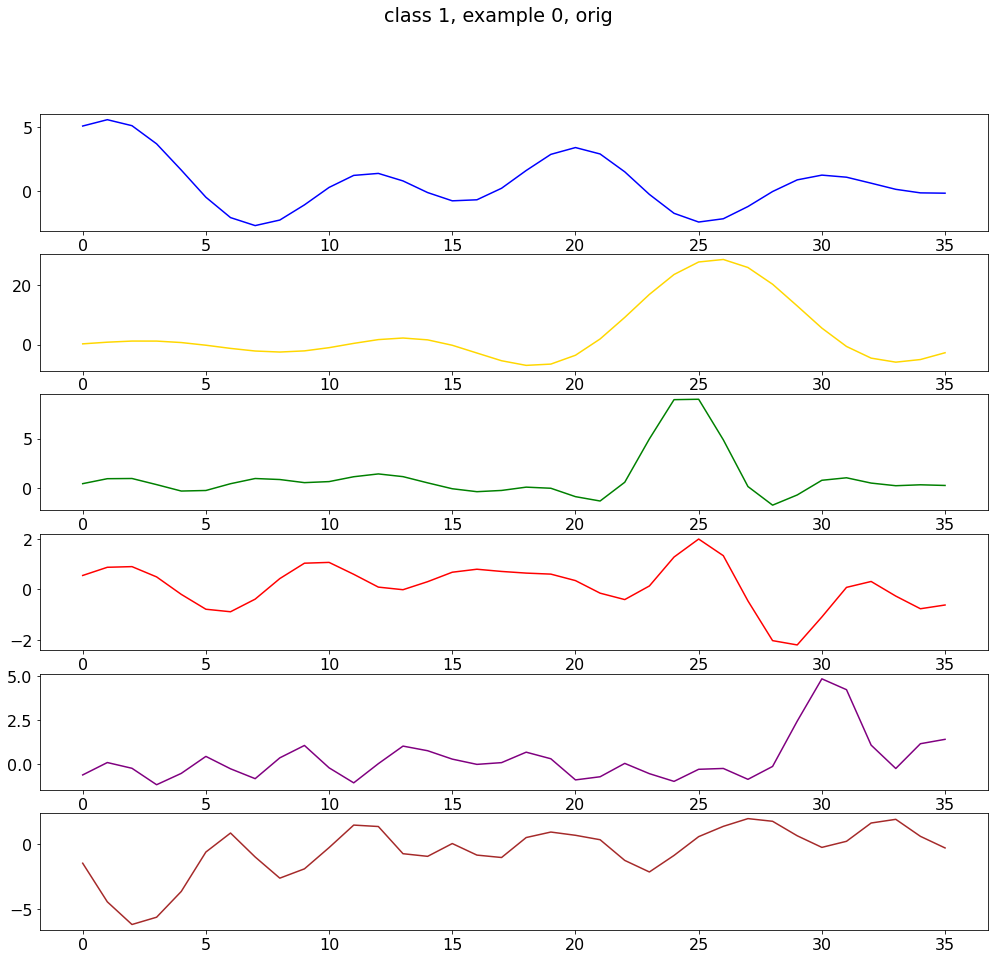

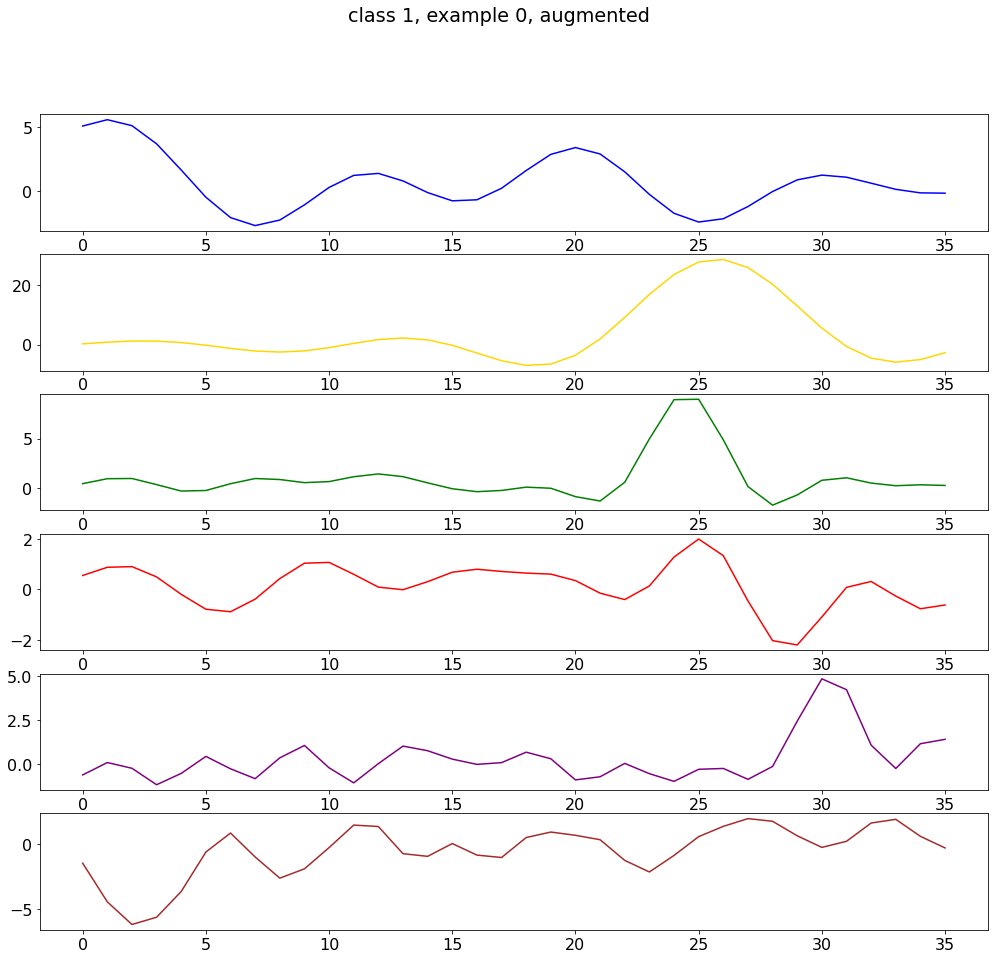

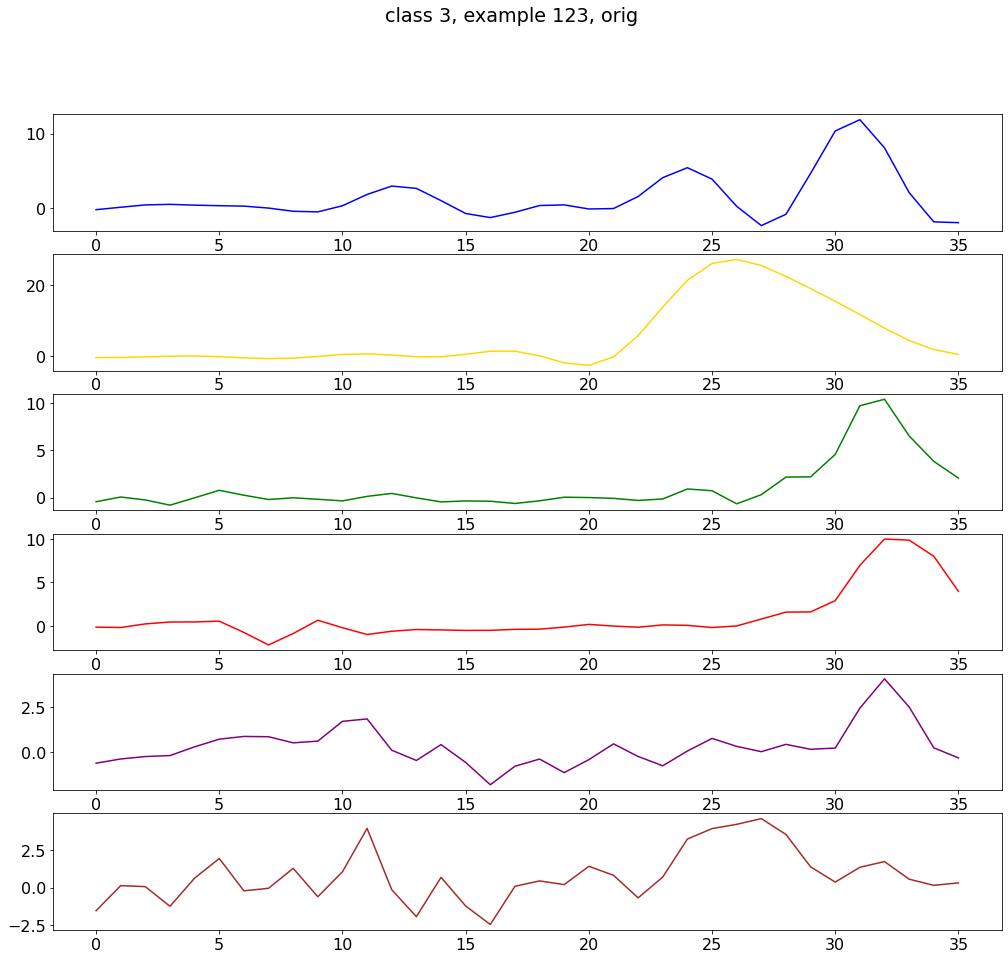

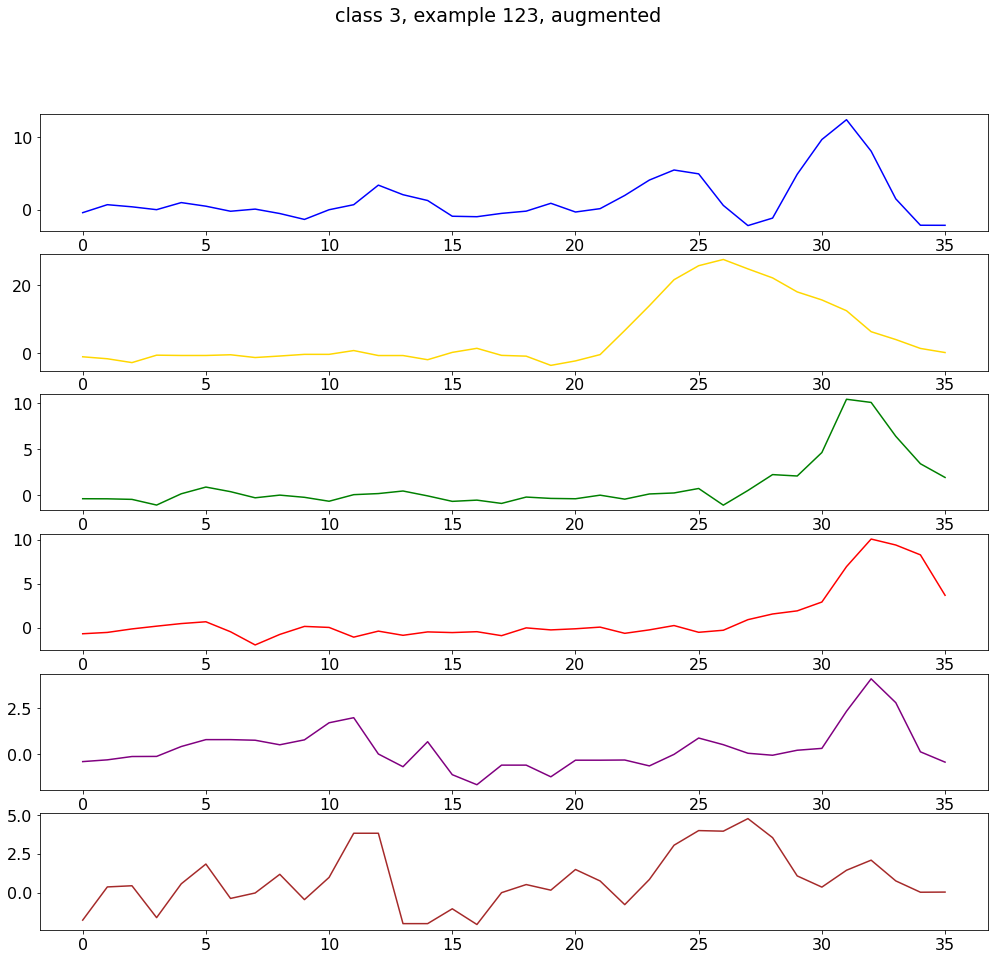

In [ ]:
random_examples = [0, 123]
for i in random_examples:
    plot_series(X_train_standardized[i], f"{y_train[i]}, example {i}, orig")
    X_i_augmented = train_generator._augment(X_train_standardized[i:i+1])[0]
    plot_series(X_i_augmented, f"{y_train[i]}, example {i}, augmented")

In [ ]:
# Train the model
log_dir = "logs/try_20_dec"
os.makedirs(log_dir)
history = model.fit(
    x=train_generator,
    epochs = epochs,
    validation_data = (X_test_standardized, y_test),
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, verbose=True, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=50, factor=0.5, min_lr=0.0001, verbose=True),
        tfk.callbacks.TensorBoard(log_dir=os.path.join(log_dir, "tensorboard")),
    ], 
    class_weight = train_class_weights
).history

FileExistsError: ignored

# **PLOT**

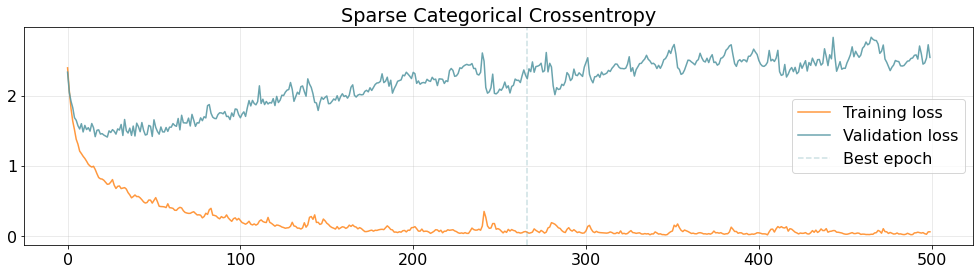

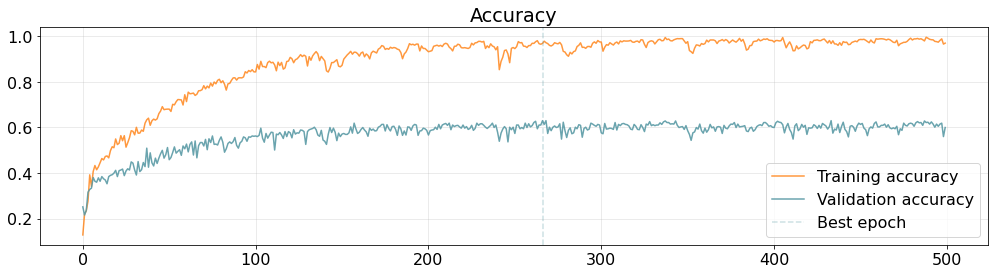

KeyError: ignored

<Figure size 1224x288 with 0 Axes>

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Sparse Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('1dCNN')
# model = tfk.models.load_model('LSTM')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test_standardized)
predictions.shape

23/23 [==============================] - 2s 43ms/step


(729, 12)

# **CONFUSION MATRIX**

Accuracy: 0.5995
Precision: 0.5185
Recall: 0.5187
F1: 0.5141


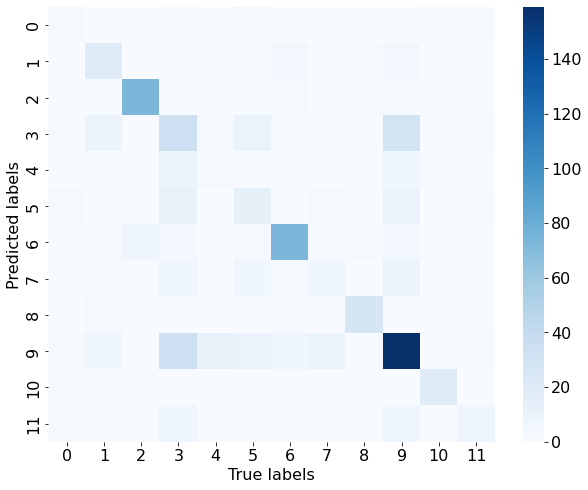

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(y_test, np.argmax(predictions, axis=-1))
precision = precision_score(y_test, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(y_test, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(y_test, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=range(classes), yticklabels=range(classes))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# **SAVE THE SCALAR WEIGHTS IN THE PICKLE FILE**

In [ ]:
import pickle
print(pickle.dumps(scaler))
print(dir(scaler))

b'\x80\x04\x95\xde\x01\x00\x00\x00\x00\x00\x00\x8c\x1bsklearn.preprocessing._data\x94\x8c\x0cRobustScaler\x94\x93\x94)\x81\x94}\x94(\x8c\x0ewith_centering\x94\x88\x8c\x0cwith_scaling\x94\x88\x8c\x0equantile_range\x94G@9\x00\x00\x00\x00\x00\x00G@R\xc0\x00\x00\x00\x00\x00\x86\x94\x8c\runit_variance\x94\x89\x8c\x04copy\x94\x88\x8c\x0en_features_in_\x94K\x06\x8c\x07center_\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x06\x85\x94h\x10\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C0\xf2\x07\x03\xcf\xbd\x87\xd1?*Ral!\xc8\xd9?\xc4\xb6E\x99\r2\xe5?\x9d\xf4\xbe\xf1\xb5g\xee?sh\x91\xed|?\xf4?\xf9\xa0g\xb3\xea3\x01@\x94t\x94b\x8c\x06scale_\x94h\x0fh\x12K\x00\x85\x94h\x14\x87\x94R\x94(K\x01K\x06\x85\x94h\x1c\x89C0\xa2E\xb6\xf3\xfd\xac"@ \xd2o_\x07N\x17@\x12\xa5\xbd\xc1\x176!@+\xf6\x97\xdd\x93\xf7(@\x06\x81

In [ ]:
print(scaler.scale_)
print(scaler.center_)
print(scaler.n_features_in_)

[ 9.337875  5.8262    8.60565  12.48355  18.252125 29.626625]
[0.27391 0.40284 0.66236 0.95016 1.2655  2.15035]
6


In [ ]:
rscaler_file = "rscaler.pkl"

# save
with open(rscaler_file, "wb") as file:
  pickle.dump(scaler, file)

# load
with open(rscaler_file, "rb") as file:
  scaler2 = pickle.load(file)

print(scaler2.scale_)
print(scaler2.center_)
print(scaler2.n_features_in_)

[ 9.337875  5.8262    8.60565  12.48355  18.252125 29.626625]
[0.27391 0.40284 0.66236 0.95016 1.2655  2.15035]
6


In [ ]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


# **VISUALIZE TENSORBOARD**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs